### Imports and Data

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import json
import gensim
from collections import Counter
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
import re
regex = re.compile('[^a-zA-Z]')
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns 
sns.set_style("ticks")

## Study II

In [2]:
#Human groups
post_survey = pd.read_csv('Color_Metaphor_Colorblindseeing.csv')
post_survey_painters = pd.read_csv('Color_Metaphor_Painters.csv')

post_survey_colorblind = post_survey[post_survey['Colorblindness 1'].values==['Yes']]
post_survey_colorseeing = post_survey[post_survey['Colorblindness 1'].values==['No']]

print(len(post_survey_painters),len(post_survey_colorblind),len(post_survey_colorseeing))

107 73 114


In [3]:
#GPT
df = {}

with open('GPT4_temp1.0_110.json','r') as f:
    data = json.loads(f.read())
df['gpt4_temp1.0'] = pd.json_normalize(data)

###

with open('GPT3_temp1.0_110.json','r') as f:
    data = json.loads(f.read())
df['gpt3_temp1.0'] = pd.json_normalize(data)

#Fix outlier response formatting
df['gpt3_temp1.0'].values[0][1][63] = df['gpt3_temp1.0'].values[0][1][63][10:]
df['gpt3_temp1.0'].values[0][3][43] = df['gpt3_temp1.0'].values[0][3][43][11:]
df['gpt3_temp1.0'].values[0][7][104] = df['gpt3_temp1.0'].values[0][7][104][11:]
df['gpt3_temp1.0'].values[0][8][3] = df['gpt3_temp1.0'].values[0][8][3][10:]
df['gpt3_temp1.0'].values[0][8][50] = df['gpt3_temp1.0'].values[0][8][50][8:]
df['gpt3_temp1.0'].values[0][8][103] = df['gpt3_temp1.0'].values[0][8][103][11:]
df['gpt3_temp1.0'].values[0][10][0] = df['gpt3_temp1.0'].values[0][10][0][11:]
df['gpt3_temp1.0'].values[0][11][14] = df['gpt3_temp1.0'].values[0][11][14][10:]
df['gpt3_temp1.0'].values[0][11][108] = df['gpt3_temp1.0'].values[0][11][108][10:]
df['gpt3_temp1.0'].values[0][17][25] = df['gpt3_temp1.0'].values[0][17][25][10:]
df['gpt3_temp1.0'].values[0][17][46] = df['gpt3_temp1.0'].values[0][17][46][10:]
df['gpt3_temp1.0'].values[0][25][55] = df['gpt3_temp1.0'].values[0][25][55][8:]
df['gpt3_temp1.0'].values[0][26][75] = df['gpt3_temp1.0'].values[0][26][75][11:]
df['gpt3_temp1.0'].values[0][27][0] = df['gpt3_temp1.0'].values[0][27][0][44:]
df['gpt3_temp1.0'].values[0][27][11] = df['gpt3_temp1.0'].values[0][27][11][46:]
df['gpt3_temp1.0'].values[0][27][16] = df['gpt3_temp1.0'].values[0][27][16][46:]
df['gpt3_temp1.0'].values[0][27][60] = df['gpt3_temp1.0'].values[0][27][60][46:]
df['gpt3_temp1.0'].values[0][27][63] = df['gpt3_temp1.0'].values[0][27][63][47:]
df['gpt3_temp1.0'].values[0][29][1] = df['gpt3_temp1.0'].values[0][29][1][11:]
df['gpt3_temp1.0'].values[0][35][10] = df['gpt3_temp1.0'].values[0][35][10][25:]
df['gpt3_temp1.0'].values[0][42][10] = df['gpt3_temp1.0'].values[0][42][10][40:]
df['gpt3_temp1.0'].values[0][42][51] = df['gpt3_temp1.0'].values[0][42][51][10:]
df['gpt3_temp1.0'].values[0][43][45] = 'He had mucus flowing from his nose'
df['gpt3_temp1.0'].values[0][43][54] = df['gpt3_temp1.0'].values[0][43][54][22:]
df['gpt3_temp1.0'].values[0][43][59] = df['gpt3_temp1.0'].values[0][43][59][10:]
df['gpt3_temp1.0'].values[0][43][78] = 'He had mucus flowing from his nose'
df['gpt3_temp1.0'].values[0][43][105] = df['gpt3_temp1.0'].values[0][43][105][10:]

###

df2 = {}

with open('GPT4_temp1.2_25.json','r') as f:
    data = json.loads(f.read())
df2['gpt4_temp1.2'] = pd.json_normalize(data)

###

df3 = {}

with open('GPT4_temp1.4_25.json','r') as f:
    data = json.loads(f.read())
df3['gpt4_temp1.4'] = pd.json_normalize(data)

In [4]:
#Metaphors
correct_answers = {}

correct_answers['novel_color'] = {'teal_death': 'Her death was peaceful', 'red_death': 'Her death was violent', 
                   'pink_idea': 'The idea was exciting','green_player': 'They were new', 
                   'crimson_day': 'The day made him feel angry', 'blue_solitutde': 'The solitude was peaceful',
                  'yellow_hike': 'The hike was energizing', 'purple_photos': 'He felt nostalgic', 
                   'magenta_date': 'She felt enamored','crimson_meeting': 'He felt enraged', 
                   'teal_meeting': 'He felt peaceful', 'burgundy_meeting': 'He felt powerful',
                  'aqua_death': 'Her death was tranquil', 'orange_speech': 'I felt energized', 
                   'yellow_speech': 'I felt inspired'}

correct_answers['frozen_color'] = {'blue_news': 'The news came unexpectedly', 'gray_area': 'The question is ambiguous', 
                                   'red_account': 'My bank account is empty', 'white_noise': 'The sound was like static',
                                  'green_recruit': "I'm unexperienced", 'black_market': 'The purchase was illegal',
                                   'red_carpet': 'They treated me royally', 'golden_opportunity': 'The opportunity is rare'}

correct_answers['novel_action'] = {'thorny_bush': 'He was looking for clues in a delicate situation', 
                                   'squeeze_orange': 'He was trying to do something very difficult and unordinary', 
                                   'fingers_frosting': 'Stay away from my business', 
                                   'sprinkled_cheer': 'They were all very affectionate of him',
                                  'all_fingers': 'The accusations all point to one person',
                                   'twisting_brain': 'I am trying in every way to understand it',
                                   'caverns_heart': 'He thought carefully about his feelings',
                                   'tack_foot': "He is someone I don't like at all",
                                  'kick_back': 'He was trying to revive a clothing style from a previous time period',
                                   'toe_stubbed': 'She was commonly the first to have a bad experience',
                                   'icy_slope': 'She was in a delicate and unstable situation', 
                                   'score_kicked': 'He brilliantly argued his closing statement'}

correct_answers['frozen_action'] = {'revealed_hand': 'He made his secret plans and intentions known',
                                    'catch_name': 'I would like you to repeat your name', 
                                    'fingers_crossed': 'Hope strongly that it will happen', 
                                    'knock_wood': "To hope for one's good luck to continue",
                                   'clock_spun': 'The time is passing quickly',
                                    'hand_point': 'He is right',
                                    'cold_feet': 'The bride was too fearful to go on with the marriage',
                                    'run_through': 'They quickly went through the steps.',
                                   'nose_running': 'He had mucus flowing from his nose',
                                    'kicked_bucket': 'He died',
                                    'last_legs': 'The pet was in a very bad condition',
                                    'leg_up': 'The hare had an advantage over the tortoise'}

###

#Re-define for painters due to minor typos 

correct_answers_painters = {}

correct_answers_painters['novel_color'] = {'teal_death': 'Her death was peaceful', 'red_death': 'Her death was violent', 
                   'pink_idea': 'The idea was exciting','green_player': 'They were new', 
                   'crimson_day': 'The day made him feel angry', 'blue_solitutde': 'The solitude was peaceful',
                  'yellow_hike': 'The hike was energizing', 'purple_photos': 'He felt nostalgic', 
                   'magenta_date': 'She felt enamored','crimson_meeting': 'He felt enraged', 
                   'teal_meeting': 'He felt peaceful', 'burgundy_meeting': 'He felt powerful',
                  'aqua_death': 'Her death was tranquil', 'orange_speech': 'I felt energized', 
                   'yellow_speech': 'I felt inspired'}

correct_answers_painters['frozen_color'] = {'blue_news': 'The news came unexpectedly', 'gray_area': 'The question is ambiguous', 
                                   'red_account': 'My bank account is empty', 'white_noise': 'The sound was like static',
                                  'green_recruit': "I'm unexperienced", 'black_market': 'The purchase was illegal',
                                   'red_carpet': 'They treated me royally', 'golden_opportunity': 'The opportunity is rare'}

correct_answers_painters['novel_action'] = {'thorny_bush': 'He was looking for clues in a delicate situation', 
                                   'squeeze_orange': 'He was trying to do something very difficult and unordinary', 
                                   'fingers_frosting': 'Stay away from my business', 
                                   'sprinkled_cheer': 'They were all very affectionate of him',
                                  'all_fingers': 'The accusations all point to one person',
                                   'twisting_brain': 'I am trying in every way to understand it',
                                   'caverns_heart': 'He thought carefully about his feelings',
                                   'tack_foot': "He is someone I don't like at all",
                                  'kick_back': 'He was trying to revive a clothing style from a previous time period',
                                   'toe_stubbed': 'She was commonly the first to have a bad experience',
                                   'icy_slope': 'She was in a delicate and unstable situation', 
                                   'score_kicked': 'He brilliantly argued his closing statement'}

correct_answers_painters['frozen_action'] = {'revealed_hand': 'He made his secret plans and intentions known',
                                    'catch_name': 'I would like you to to repeat your name', 
                                    'fingers_crossed': 'Hope strongly that it will happen', 
                                    'knock_wood': "To hope for one's good luck to continue",
                                   'clock_spun': 'The time is passing quickly',
                                    'hand_point': 'He is right',
                                    'cold_feet': 'The bride was too fearful to go on with the marriage',
                                    'run_through': 'They quickly went through the steps.',
                                   'nose_running': 'He had mucus flowing from his nose',
                                    'kicked_bucket': 'He died',
                                    'last_legs': 'The pet was in a very bad condition',
                                    'leg_up': 'The hare had an advantage over the tortoise'}

In [5]:
category_keys=['novel_color','frozen_color','novel_action','frozen_action']

colorblind_correct_all = {}
colorblind_tot_all = {}

colorseeing_correct_all = {}
colorseeing_tot_all = {}

painter_correct_all = {}
painter_tot_all = {}

gpt_correct_all = {}
gpt_tot_all = {}

for category_key in category_keys:
    colorblind_dict = {}
    colorblind_correct = 0
    colorblind_tot = 0

    colorseeing_dict = {}
    colorseeing_correct = 0
    colorseeing_tot = 0

    painter_dict = {}
    painter_correct = 0
    painter_tot = 0

    for key in correct_answers[category_key].keys():
        colorblind_dict[key] = {}
        colorseeing_dict[key] = {}
        painter_dict[key] = {}
        ###
        print(key, ' fraction correct')
        colorblind_answers = post_survey_colorblind[key].values[2:]
        colorblind_answers = np.array([element for element in colorblind_answers if type(element)==str])
        answers = np.unique(colorblind_answers)
        for answer in answers:
            colorblind_dict[key][answer] = len(colorblind_answers[colorblind_answers==answer])/(1.*len(colorblind_answers))
        ###
        frac_correct = len(colorblind_answers[colorblind_answers==correct_answers[category_key][key]])/(1.*len(colorblind_answers))
        colorblind_correct += len(colorblind_answers[colorblind_answers==correct_answers[category_key][key]])
        colorblind_tot += len(colorblind_answers)
        print('colorblind, {:.2f}'.format(frac_correct))
        ###
        colorseeing_answers = post_survey_colorseeing[key].values[2:]
        colorseeing_answers = np.array([element for element in colorseeing_answers if type(element)==str])
        answers = np.unique(colorseeing_answers)
        for answer in answers:
            colorseeing_dict[key][answer] = len(colorseeing_answers[colorseeing_answers==answer])/(1.*len(colorseeing_answers))
        ###
        frac_correct = len(colorseeing_answers[colorseeing_answers==correct_answers[category_key][key]])/(1.*len(colorseeing_answers))
        colorseeing_correct += len(colorseeing_answers[colorseeing_answers==correct_answers[category_key][key]])
        colorseeing_tot += len(colorseeing_answers)
        print('colorseeing, {:.2f}'.format(frac_correct))
        ###
        painter_answers = post_survey_painters[key].values[2:]
        painter_answers = np.array([element for element in painter_answers if type(element)==str])
        answers = np.unique(painter_answers)
        for answer in answers:
            painter_dict[key][answer] = len(painter_answers[painter_answers==answer])/(1.*len(painter_answers))
        ###
        frac_correct = len(painter_answers[painter_answers==correct_answers_painters[category_key][key]])/(1.*len(painter_answers))
        painter_correct += len(painter_answers[painter_answers==correct_answers_painters[category_key][key]])
        painter_tot += len(painter_answers)
        print('painters, {:.2f}'.format(frac_correct))

        print('\n')
        
    colorblind_correct_all[category_key] = colorblind_correct
    colorblind_tot_all[category_key] = colorblind_tot
    
    colorseeing_correct_all[category_key] = colorseeing_correct
    colorseeing_tot_all[category_key] = colorseeing_tot
    
    painter_correct_all[category_key] = painter_correct
    painter_tot_all[category_key] = painter_tot
    
    ###
    
    gpt_dict = {}
    gpt_correct = 0
    gpt_tot = 0

    category_key_i_mapping = {'novel_color':0,'frozen_color':15,'novel_action':23,'frozen_action':35}

    for key in df.keys():
        if key == 'gpt3_temp1.5':
            continue
        if key == 'gpt4_temp1.0':
            continue
        gpt_dict[key] = {}
        i = category_key_i_mapping[category_key]
        for q in correct_answers_painters[category_key].keys():
            print(q)
            gpt_dict[key][q] = {}
            gpt_answers = np.array(df[key].values[0][i]) #df[key]['{}'.format(i)].values[0]
            for k,ans in enumerate(gpt_answers):
                if ans.startswith('1.') or ans.startswith('2.') or ans.startswith('3.'):
                    gpt_answers[k] = gpt_answers[k][3:]
                if ans.endswith('.'):
                    gpt_answers[k] = gpt_answers[k][:-1]
            answers = np.unique(gpt_answers)
            for answer in answers:
                gpt_dict[key][q][answer] = len(gpt_answers[gpt_answers==answer])/(1.*len(gpt_answers))
            gpt_correct += len(gpt_answers[gpt_answers==correct_answers_painters[category_key][q]])
            gpt_tot += len(gpt_answers)
            i+=1
        print(gpt_dict[key])
        print('\n')
        
    gpt_correct_all[category_key] = gpt_correct
    gpt_tot_all[category_key] = gpt_tot
    
#GPT answered all frozen action metaphors correctly, but there were some typos; set to 100%
gpt_correct_all['frozen_action'] = 1320

teal_death  fraction correct
colorblind, 0.83
colorseeing, 0.76
painters, 0.74


red_death  fraction correct
colorblind, 0.99
colorseeing, 0.97
painters, 0.95


pink_idea  fraction correct
colorblind, 0.72
colorseeing, 0.71
painters, 0.76


green_player  fraction correct
colorblind, 0.96
colorseeing, 0.95
painters, 0.89


crimson_day  fraction correct
colorblind, 0.89
colorseeing, 0.88
painters, 0.84


blue_solitutde  fraction correct
colorblind, 0.62
colorseeing, 0.62
painters, 0.62


yellow_hike  fraction correct
colorblind, 0.69
colorseeing, 0.38
painters, 0.59


purple_photos  fraction correct
colorblind, 0.79
colorseeing, 0.75
painters, 0.78


magenta_date  fraction correct
colorblind, 0.66
colorseeing, 0.67
painters, 0.68


crimson_meeting  fraction correct
colorblind, 0.89
colorseeing, 0.88
painters, 0.79


teal_meeting  fraction correct
colorblind, 0.85
colorseeing, 0.84
painters, 0.86


burgundy_meeting  fraction correct
colorblind, 0.62
colorseeing, 0.64
painters, 0.61


aqua

In [6]:
#Group comparisons
for key in category_keys:
    print(key)
    nobs = np.array([gpt_tot_all[key],colorblind_tot_all[key]])
    count = np.array([gpt_correct_all[key],colorblind_correct_all[key]])
    stat, pval = proportions_ztest(count, nobs)
    print('{}:'.format(key), 'gpt ({:.2f}) x colorblind ({:.2f}), z={:.6f}, p={:.6f}'.format(gpt_correct_all[key]/gpt_tot_all[key],
                                                                                   colorblind_correct_all[key]/colorblind_tot_all[key],
                                                                                   stat,pval))

    nobs = np.array([colorblind_tot_all[key],colorseeing_tot_all[key]])
    count = np.array([colorblind_correct_all[key],colorseeing_correct_all[key]])
    stat, pval = proportions_ztest(count, nobs)
    print('{}:'.format(key), 'colorblind ({:.2f}) x colorseeing ({:.2f}), z={:.6f}, p={:.3f}'.format(colorblind_correct_all[key]/colorblind_tot_all[key],
                                                                                   colorseeing_correct_all[key]/colorseeing_tot_all[key],
                                                                                   stat, pval))

    nobs = np.array([painter_tot_all[key],colorseeing_tot_all[key]])
    count = np.array([painter_correct_all[key],colorseeing_correct_all[key]])
    stat, pval = proportions_ztest(count, nobs)
    print('{}:'.format(key), 'painter ({:.2f}) x colorseeing ({:.2f}), z={:.6f}, p={:.4f}'.format(painter_correct_all[key]/painter_tot_all[key],
                                                                                   colorseeing_correct_all[key]/colorseeing_tot_all[key],
                                                                                   stat,pval))
    
    nobs = np.array([painter_tot_all[key],colorblind_tot_all[key]])
    count = np.array([painter_correct_all[key],colorblind_correct_all[key]])
    stat, pval = proportions_ztest(count, nobs)
    print('{}:'.format(key), 'painter ({:.2f}) x colorblind ({:.2f}), z={:.6f}, p={:.4f}'.format(painter_correct_all[key]/painter_tot_all[key],
                                                                                   colorblind_correct_all[key]/colorblind_tot_all[key],
                                                                                   stat,pval))
    
    print('\n')

novel_color
novel_color: gpt (0.74) x colorblind (0.76), z=-1.191786, p=0.233345
novel_color: colorblind (0.76) x colorseeing (0.72), z=2.723903, p=0.006
novel_color: painter (0.75) x colorseeing (0.72), z=2.310186, p=0.0209
novel_color: painter (0.75) x colorblind (0.76), z=-0.571364, p=0.5678


frozen_color
frozen_color: gpt (0.96) x colorblind (0.99), z=-3.091399, p=0.001992
frozen_color: colorblind (0.99) x colorseeing (0.98), z=1.531513, p=0.126
frozen_color: painter (0.95) x colorseeing (0.98), z=-2.961192, p=0.0031
frozen_color: painter (0.95) x colorblind (0.99), z=-3.795369, p=0.0001


novel_action
novel_action: gpt (0.99) x colorblind (0.97), z=3.190538, p=0.001420
novel_action: colorblind (0.97) x colorseeing (0.97), z=-0.661718, p=0.508
novel_action: painter (0.95) x colorseeing (0.97), z=-2.353283, p=0.0186
novel_action: painter (0.95) x colorblind (0.97), z=-1.437865, p=0.1505


frozen_action
frozen_action: gpt (1.00) x colorblind (0.98), z=5.219696, p=0.000000
frozen_act

/Users/eon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in sqrt


(0.675, 1.025)

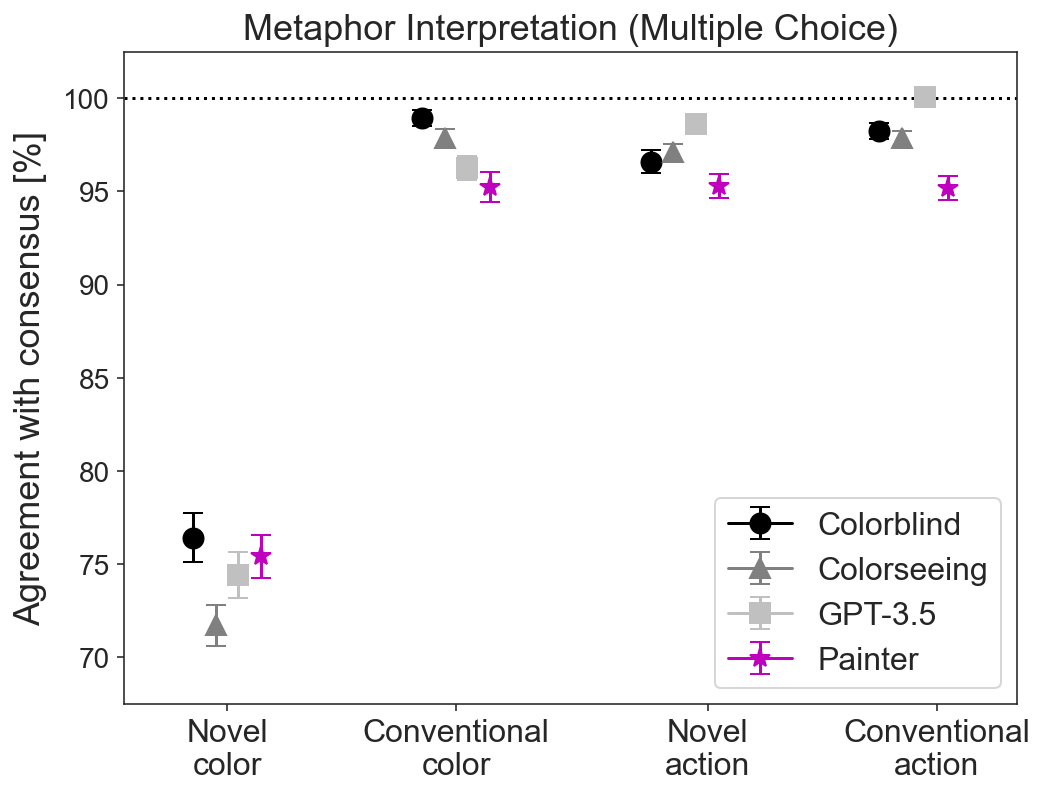

In [7]:
plt.figure(figsize=(8,6))

frac = colorblind_correct_all['novel_color']/colorblind_tot_all['novel_color']
plt.errorbar(0,frac,
            yerr=np.sqrt(frac*(1.-frac)/colorblind_tot_all['novel_color']),
            marker='o',markersize=10,capsize=5,c='k')

frac = colorseeing_correct_all['novel_color']/colorseeing_tot_all['novel_color']
plt.errorbar(0.1,colorseeing_correct_all['novel_color']/colorseeing_tot_all['novel_color'],
            yerr=np.sqrt(frac*(1.-frac)/colorseeing_tot_all['novel_color']),
            marker='^',markersize=10,capsize=5,c='gray')

frac = painter_correct_all['novel_color']/painter_tot_all['novel_color']
plt.errorbar(0.3,painter_correct_all['novel_color']/painter_tot_all['novel_color'],
            yerr=np.sqrt(frac*(1.-frac)/painter_tot_all['novel_color']),
            marker='*',markersize=10,capsize=5,c='m')

plt.errorbar(0.2,gpt_correct_all['novel_color']/gpt_tot_all['novel_color'],
            yerr=np.sqrt(gpt_tot_all['novel_color']-gpt_correct_all['novel_color'])/gpt_tot_all['novel_color'],
            marker='s',markersize=10,capsize=5,c='silver')
###

frac = colorblind_correct_all['frozen_color']/colorblind_tot_all['frozen_color']
plt.errorbar(1,frac,
            yerr=np.sqrt(frac*(1.-frac)/colorblind_tot_all['frozen_color']),
            marker='o',markersize=10,capsize=5,c='k',label='Colorblind')

frac = colorseeing_correct_all['frozen_color']/colorseeing_tot_all['frozen_color']
plt.errorbar(1.1,colorseeing_correct_all['frozen_color']/colorseeing_tot_all['frozen_color'],
            yerr=np.sqrt(frac*(1.-frac)/colorseeing_tot_all['frozen_color']),
            marker='^',markersize=10,capsize=5,c='gray',label='Colorseeing')

plt.errorbar(1.2,gpt_correct_all['frozen_color']/gpt_tot_all['frozen_color'],
            yerr=np.sqrt(gpt_tot_all['frozen_color']-gpt_correct_all['frozen_color'])/gpt_tot_all['frozen_color'],
            marker='s',markersize=10,capsize=5,c='silver',label='GPT-3.5')

frac = painter_correct_all['frozen_color']/painter_tot_all['frozen_color']
plt.errorbar(1.3,painter_correct_all['frozen_color']/painter_tot_all['frozen_color'],
            yerr=np.sqrt(frac*(1.-frac)/painter_tot_all['frozen_color']),
            marker='*',markersize=10,capsize=5,c='m',label='Painter')
###

frac = colorblind_correct_all['novel_action']/colorblind_tot_all['novel_action']
plt.errorbar(2,frac,
            yerr=np.sqrt(frac*(1.-frac)/colorblind_tot_all['novel_action']),
            marker='o',markersize=10,capsize=5,c='k')

frac = colorseeing_correct_all['novel_action']/colorseeing_tot_all['novel_action']
plt.errorbar(2.1,colorseeing_correct_all['novel_action']/colorseeing_tot_all['novel_action'],
            yerr=np.sqrt(frac*(1.-frac)/colorseeing_tot_all['novel_action']),
            marker='^',markersize=10,capsize=5,c='gray')

plt.errorbar(2.2,gpt_correct_all['novel_action']/gpt_tot_all['novel_action'],
            yerr=np.sqrt(gpt_tot_all['novel_action']-gpt_correct_all['novel_action'])/gpt_tot_all['novel_action'],
            marker='s',markersize=10,capsize=5,c='silver')

frac = painter_correct_all['novel_action']/painter_tot_all['novel_action']
plt.errorbar(2.3,painter_correct_all['novel_action']/painter_tot_all['novel_action'],
            yerr=np.sqrt(frac*(1.-frac)/painter_tot_all['novel_action']),
            marker='*',markersize=10,capsize=5,c='m')
###

frac = colorblind_correct_all['frozen_action']/colorblind_tot_all['frozen_action']
plt.errorbar(3,frac,
            yerr=np.sqrt(frac*(1.-frac)/colorblind_tot_all['frozen_action']),
            marker='o',markersize=10,capsize=5,c='k')

frac = colorseeing_correct_all['frozen_action']/colorseeing_tot_all['frozen_action']
plt.errorbar(3.1,colorseeing_correct_all['frozen_action']/colorseeing_tot_all['frozen_action'],
            yerr=np.sqrt(frac*(1.-frac)/colorseeing_tot_all['frozen_action']),
            marker='^',markersize=10,capsize=5,c='gray')

plt.errorbar(3.2,gpt_correct_all['frozen_action']/gpt_tot_all['frozen_action'],
            yerr=np.sqrt(gpt_tot_all['frozen_action']-gpt_correct_all['frozen_action'])/gpt_tot_all['frozen_action'],
            marker='s',markersize=10,capsize=5,c='silver')

frac = painter_correct_all['frozen_action']/painter_tot_all['frozen_action']
plt.errorbar(3.3,painter_correct_all['frozen_action']/painter_tot_all['frozen_action'],
            yerr=np.sqrt(frac*(1.-frac)/painter_tot_all['frozen_action']),
            marker='*',markersize=10,capsize=5,c='m')
###

plt.plot(np.linspace(-0.3,3.6,10),np.ones(10),'k:')

plt.xticks([0.15,1.15,2.25,3.25],['Novel\ncolor', 'Conventional\ncolor', 'Novel\naction', 'Conventional\naction'],fontsize=16)
plt.legend(loc=4,fontsize=16)
plt.title('Metaphor Interpretation (Multiple Choice)',fontsize=18)
plt.ylabel('Agreement with consensus [%]',fontsize=18,labelpad=8)
plt.yticks([0.7,0.75,0.8,0.85,0.9,0.95,1.],['70','75','80','85','90','95','100'],fontsize=14)
plt.xlim(-0.3,3.6)
plt.ylim(0.675,1.025)